### 用户RFM数据分析

#### 导入数据

In [19]:
# 设置参数
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_excel(r"D:\ProgramData\data\excel_data\用户购买行为数据分析.xlsx",sheet_name="RFM分析")
data.head()

,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市
0,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市
1,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市
2,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市
3,重碎叠,2019-01-01 10:00:07,交易成功,197,0,江苏省,南京市
4,iho_jann,2019-01-01 10:00:08,交易成功,168,0,广东省,广州市


#### 查看数据缺失值

In [3]:
data.isna().sum()

买家昵称    0
付款日期    0
订单状态    0
实付金额    0
邮费      0
省份      0
城市      0
dtype: int64

#### 查看/删除重复数据

In [4]:
# 查看重复数据
data.duplicated(subset=["买家昵称","付款日期","订单状态","实付金额","省份","城市"]).sum()
# 删除重复数据
data.drop_duplicates(subset=["买家昵称","付款日期","订单状态","实付金额","省份","城市"],inplace=True,keep="first")

#### 查看数据完整性

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   买家昵称    1999 non-null   object        
 1   付款日期    1999 non-null   datetime64[ns]
 2   订单状态    1999 non-null   object        
 3   实付金额    1999 non-null   int64         
 4   邮费      1999 non-null   int64         
 5   省份      1999 non-null   object        
 6   城市      1999 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 124.9+ KB


#### RFM指标建立

In [6]:
# 用户数量
data.买家昵称.nunique()
# 共1958位用户

1958

##### 指标分析
R - 多久没来  
F - 买了多少次  
M - 花了多少钱  
需要数据：用户最后一次购买的时间，用户在最终时间之前购买了多少次，以及用户共花费了多少钱

In [7]:
last_time_fir = data.付款日期.max()
last_time_fir       # '2019-01-11 09:58:38'

Timestamp('2019-01-11 09:58:38')

In [8]:
# 取截至时间为2019-3-1
last_time = "2019-3-1"

##### 获取所需要的数据

In [9]:
# 计算用户多久没来
import time
data_time = data.groupby("买家昵称",as_index=False)["付款日期"].max()
gs_time = [str(i)[:19] for i in data_time["付款日期"].tolist()]
time_cuo = [time.mktime(time.strptime(i,"%Y-%m-%d %H:%M:%S")) for i in gs_time]
data_time["多久没来"] = [(time.mktime(time.strptime(last_time,"%Y-%m-%d")) - i) for i in time_cuo]
data_time["多久没来"] = np.around(data_time["多久没来"]/(3600*24),2)
data_time.head()

,买家昵称,付款日期,多久没来
0,.willn1,2019-01-11 03:46:18,48.84
1,.托托m,2019-01-11 02:26:33,48.90
2,0amy_lee198508,2019-01-11 07:44:48,48.68
3,0anmin2,2019-01-11 02:43:24,48.89
4,0baikepray21,2019-01-11 01:34:03,48.93


In [10]:
# 计算多久没来的平均值
R_mean = data_time.多久没来.mean()
R_mean

49.34442798774259

In [11]:
# 用户"多久没来"值高于R_mean，标记为"远"，否则标记为"近"
data_time["R"] = np.where(data_time.多久没来 > R_mean,"远","近")
data_time.head()

,买家昵称,付款日期,多久没来,R
0,.willn1,2019-01-11 03:46:18,48.84,近
1,.托托m,2019-01-11 02:26:33,48.90,近
2,0amy_lee198508,2019-01-11 07:44:48,48.68,近
3,0anmin2,2019-01-11 02:43:24,48.89,近
4,0baikepray21,2019-01-11 01:34:03,48.93,近


In [12]:
# 统计各用户的购买次数，并计算平均值
data_time["购买次数"] = data.groupby("买家昵称",as_index=False)["订单状态"].count().订单状态
count_mean = data_time.购买次数.mean()
count_mean

1.0209397344228806

In [13]:
# 增加data_time的"F"列
data_time["F"] = np.where(data_time.购买次数 > count_mean,"高","低")
data_time.head()

,买家昵称,付款日期,多久没来,R,购买次数,F
0,.willn1,2019-01-11 03:46:18,48.84,近,1,低
1,.托托m,2019-01-11 02:26:33,48.90,近,1,低
2,0amy_lee198508,2019-01-11 07:44:48,48.68,近,1,低
3,0anmin2,2019-01-11 02:43:24,48.89,近,1,低
4,0baikepray21,2019-01-11 01:34:03,48.93,近,1,低


In [14]:
# 统计各用户的购买金额
data_time["购买金额"] = data.groupby("买家昵称",as_index=False)["实付金额"].sum().实付金额
data_time.head()

,买家昵称,付款日期,多久没来,R,购买次数,F,购买金额
0,.willn1,2019-01-11 03:46:18,48.84,近,1,低,34
1,.托托m,2019-01-11 02:26:33,48.90,近,1,低,37
2,0amy_lee198508,2019-01-11 07:44:48,48.68,近,1,低,88
3,0anmin2,2019-01-11 02:43:24,48.89,近,1,低,78
4,0baikepray21,2019-01-11 01:34:03,48.93,近,1,低,178


In [15]:
# 根据多久没来/购买次数/购买金额[0-25,25-50,50-75,75-100]区间，对用户进行分组
data_time.describe()

,多久没来,购买次数,购买金额
count,1958.000000,1958.000000,1958.000000
mean,49.344428,1.020940,109.871808
std,1.849671,0.146744,65.241084
min,48.580000,1.000000,30.000000
25%,48.670000,1.000000,72.000000
50%,48.870000,1.000000,82.000000
75%,48.950000,1.000000,148.000000
max,58.990000,3.000000,507.000000


##### 根据"购买金额"指标分组

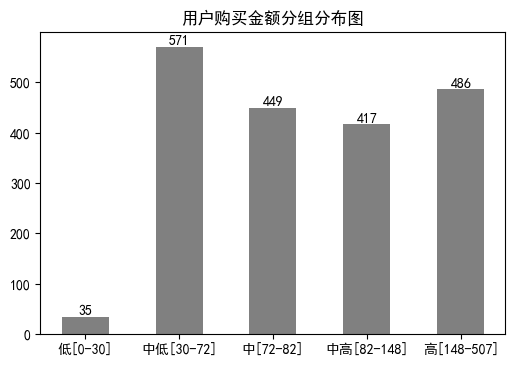

In [20]:
data_m = pd.cut(data_time.购买金额,bins=[0,30,72,82,148,507])
data_m = pd.DataFrame(data_m)
data_m["userid"] = [1 for i in range(1,1959)]
data_mus = data_m.groupby("购买金额",as_index=False)["userid"].sum()
# 可视化
bar = plt.bar(data_mus.index,data_mus.userid,width=0.5,color="gray")
plt.bar_label(bar)
plt.xticks([0,1,2,3,4],labels=["低[0-30]","中低[30-72]","中[72-82]","中高[82-148]","高[148-507]"])
plt.title("用户购买金额分组分布图")
plt.show()

##### 根据"多久没来"指标分组

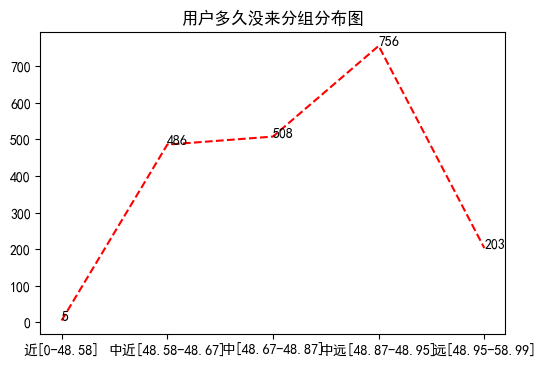

In [21]:
data_r = pd.cut(data_time.多久没来,bins=[0,48.58,48.67,48.87,48.95,58.99])
data_r = pd.DataFrame(data_r)
data_r["userid"] = [1 for i in range(1958)]
data_rus = data_r.groupby("多久没来",as_index=False)["userid"].sum()
data_rus.columns = ["howlong","userid"]

# 可视化
plt.plot(data_rus.index,data_rus.userid,"--r")
plt.xticks([0,1,2,3,4,],labels=["近[0-48.58]","中近[48.58-48.67]","中[48.67-48.87]","中远[48.87-48.95]","远[48.95-58.99]"])
for i in [0,1,2,3,4]:
    plt.text(i,data_rus.userid[i],data_rus.userid[i])
plt.title("用户多久没来分组分布图")
plt.show()

In [22]:
# 计算购买金额的均值，增加data_time的M列
cost_mean = data_time.购买金额.mean()
# cost_mean
data_time["M"] = np.where(data_time.购买金额 > cost_mean,"高","低")
data_time.head()

,买家昵称,付款日期,多久没来,R,购买次数,F,购买金额,M
0,.willn1,2019-01-11 03:46:18,48.84,近,1,低,34,低
1,.托托m,2019-01-11 02:26:33,48.90,近,1,低,37,低
2,0amy_lee198508,2019-01-11 07:44:48,48.68,近,1,低,88,低
3,0anmin2,2019-01-11 02:43:24,48.89,近,1,低,78,低
4,0baikepray21,2019-01-11 01:34:03,48.93,近,1,低,178,高


In [23]:
# 删除data_time的"多久没来"、"购买次数"、"购买金额"列
del data_time["多久没来"]
del data_time["购买次数"]
del data_time["购买金额"]

##### 获得用户的RFM指标

In [24]:
# 获得用户的RFM指标
data_time["RFM"] = data_time.R + data_time.F + data_time.M
data_time.head()

,买家昵称,付款日期,R,F,M,RFM
0,.willn1,2019-01-11 03:46:18,近,低,低,近低低
1,.托托m,2019-01-11 02:26:33,近,低,低,近低低
2,0amy_lee198508,2019-01-11 07:44:48,近,低,低,近低低
3,0anmin2,2019-01-11 02:43:24,近,低,低,近低低
4,0baikepray21,2019-01-11 01:34:03,近,低,高,近低高


##### 根据RFM指标，对用户进行评级

In [25]:
ad_rfm = {"近高高":"高价值客户","远高高":"重点保持客户","近低高":"重点发展客户","远低高":"重点挽留客户",
            "近高低":"一般价值客户","远高低":"一般保持客户","近低低":"一般发展客户","远低低":"潜在客户"}
data_time["RFM指标"] = [ad_rfm[i] for i in data_time.RFM]
data_time.head()

,买家昵称,付款日期,R,F,M,RFM,RFM指标
0,.willn1,2019-01-11 03:46:18,近,低,低,近低低,一般发展客户
1,.托托m,2019-01-11 02:26:33,近,低,低,近低低,一般发展客户
2,0amy_lee198508,2019-01-11 07:44:48,近,低,低,近低低,一般发展客户
3,0anmin2,2019-01-11 02:43:24,近,低,低,近低低,一般发展客户
4,0baikepray21,2019-01-11 01:34:03,近,低,高,近低高,重点发展客户


#### 销售额分析

In [26]:
data.head()

,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市
0,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市
1,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市
2,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市
3,重碎叠,2019-01-01 10:00:07,交易成功,197,0,江苏省,南京市
4,iho_jann,2019-01-01 10:00:08,交易成功,168,0,广东省,广州市


##### 按时间分析销售额

In [27]:
import time
data_tsal = data[["付款日期","实付金额"]]
# time.strptime(str(data_tsal.付款日期.tolist()[0]),"%Y-%m-%d %H:%M:%S")
timeli = data_tsal.付款日期.tolist()
# time.strptime(str(data_tsal.付款日期.tolist()[0]),"%Y-%m-%d %H:%M:%S")
time0 = [str(timeli[i]) for i in range(len(timeli))]
time_fin = [time.strftime("%Y-%m-%d",time.strptime(i[:10],"%Y-%m-%d")) for i in time0]

In [28]:
data_tsal["付款日期"] = time_fin
data_tsal.head()

C:\Users\12562\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,付款日期,实付金额
0,2019-01-01,186
1,2019-01-01,145
2,2019-01-01,194
3,2019-01-01,197
4,2019-01-01,168


In [29]:
data_finsal = data_tsal.groupby("付款日期",as_index=False)["实付金额"].sum()
data_finsal

,付款日期,实付金额
0,2019-01-01,4262
1,2019-01-02,2336
2,2019-01-03,4410
3,2019-01-04,4185
4,2019-01-05,2741
5,2019-01-06,3716
6,2019-01-07,2668
7,2019-01-08,4475
8,2019-01-09,2319
9,2019-01-10,1509


可以看出1-11的数据有明显异常，根据原始数据记录，是由于其中大部分数据都是11月的原因，  
因此在这里便不在对11月数据进行可视化。

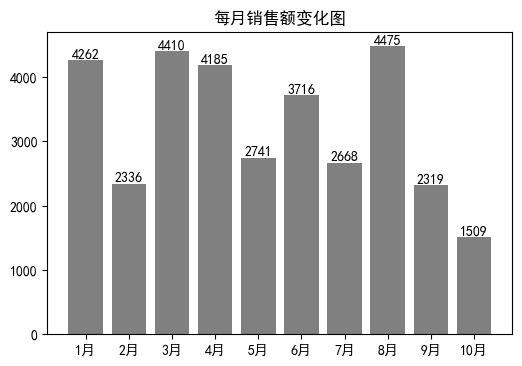

In [30]:
# 对前十个月的数据进行数据可视化
data_show = data_finsal[:10]
var = plt.bar(data_show.付款日期,data_show.实付金额,color = "gray")
plt.xticks([i for i in range(0,10)],labels=[str(i)+"月" for i in range(1,11)])
plt.title("每月销售额变化图")
plt.bar_label(var)
plt.show()

##### 按地点对销售额可视化分析

In [31]:
data_plsa = data[["实付金额","省份","城市"]]
data_plsa.head()

,实付金额,省份,城市
0,186,上海,上海市
1,145,广东省,广州市
2,194,山东省,东营市
3,197,江苏省,南京市
4,168,广东省,广州市


In [32]:
# 按省份分组
sal_pr = data_plsa.groupby("省份",as_index=False)["实付金额"].sum()
sal_pr.head()

,省份,实付金额
0,上海,50853
1,云南省,1431
2,内蒙古自治区,2059
3,北京,16429
4,吉林省,1633


In [33]:
sal_pr.describe()

,实付金额
count,29.000000
mean,7418.241379
std,10900.452018
min,79.000000
25%,2059.000000
50%,3377.000000
75%,8428.000000
max,50853.000000


In [34]:
# 地图可视化
from pyecharts import options as opts
from pyecharts.charts import Page,Scatter,Map,Geo
from pyecharts.globals import ThemeType,ChartType

In [35]:
map = (
    Map()
    .add("销售额",data_pair=[list(i) for i in zip(sal_pr.省份.tolist(),sal_pr.实付金额.tolist())],maptype="china")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各省份销售额"),
        visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                                            pieces=[{"min":0,"max":79,"lable":"0-79","color":"blue"},
                                                    {"min":79,"max":2059,"lable":"79-2059","color":"cyan"},
                                                    {"min":2059,"max":3377,"label":"2059-3377","color":"gray"},
                                                    {"min":3377,"max":8428,"label":"3377-8428","color":"yellow"},
                                                    {"min":8428,"max":51000,"label":"8428-51000","color":"red"}])
    )
)
map.render_notebook()

In [39]:
# 按城市分组
data_citysal = data_plsa.groupby("城市",as_index=False)["实付金额"].sum()

map1 = (
    Geo()
    .add("销售额",data_pair=[list(i) for i in zip(data_citysal.城市.tolist(),data_citysal.实付金额.tolist())],
        # type_=ChartType.EFFECT_SCATTER,
        # effect_opts=opts.EffectOpts(symbol_size=2)
    )
    .add_schema(maptype="china")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各城市销售额",subtitle="标签：城市"),
        visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                                            pieces=[{"min":0,"max":30,"lable":"0-30","color":"blue"},
                                                    {"min":30,"max":115,"lable":"30-115","color":"cyan"},
                                                    {"min":115,"max":266,"label":"115-266","color":"gray"},
                                                    {"min":266,"max":660,"label":"266-660","color":"yellow"},
                                                    {"min":660,"max":51000,"label":"660-51000","color":"red"}])
    )
)
map1.render_notebook()